<h1 style='color:purple' align='center'>P. alan Joseph</h1>

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score  
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

#### Reading Data

In [2]:
data = pd.read_csv(r'C:\Users\LENOVO\Downloads\Train.csv')

In [3]:
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
data.shape

(13320, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
for column in data.columns:
       print(data[column].value_counts())
       print("*"*20)

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64
********************
availability
Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
15-Aug               1
17-Jan               1
16-Nov               1
16-Jan               1
14-Jul               1
Name: count, Length: 81, dtype: int64
********************
location
Whitefield                        540
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1305, dtype: int64
********************
size
2 BHK    

## Exploratory Data Analysis and Feature Engineering

### Null Values

In [7]:
data.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

<Axes: xlabel='price', ylabel='area_type'>

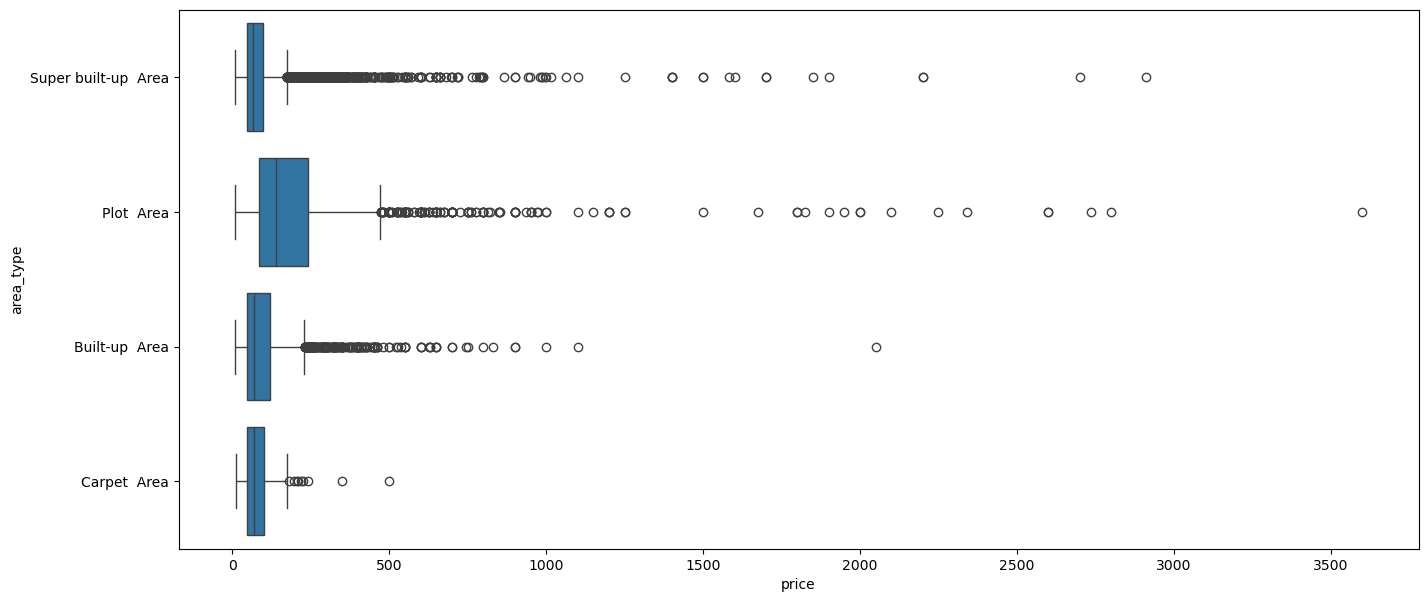

In [8]:
plt.figure(figsize=(16,7))
sns.boxplot(x=data['price'],y=data['area_type'])

##### We observe that the nulls in "Society" column which is 5502 and other columns like "area_type","availability,"balcony" also have many nulls. We remove those columns not only because of the number of nulls but also because of the relavance of these columns to our model is redundant.

In [9]:
data.drop(columns=["area_type","availability","society","balcony"],inplace=True)

In [10]:
data.describe()

,bath,price
count,13247.000000,13320.000000
mean,2.692610,112.565627
std,1.341458,148.971674
min,1.000000,8.000000
25%,2.000000,50.000000
50%,2.000000,72.000000
75%,3.000000,120.000000
max,40.000000,3600.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13319 non-null  object 
 1   size        13304 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13247 non-null  float64
 4   price       13320 non-null  float64
dtypes: float64(2), object(3)
memory usage: 520.4+ KB


## Filling the Missing Values - Columns Wise


#### Location Column

In [12]:
data['location'].isna().sum()

1

In [13]:
#We have only 1 missing value in the Location column, so filling it with a random value say 'Sarjapur Road' to fill in the data, as this would not signigicantly affect the model
data['location']=data['location'].fillna('Sarjapur Road')

#### Size Column

In [14]:
data['size'].isna().sum()

16

In [15]:
data['size'] = data['size'].fillna('2 BHK') 

#### Bath Column

In [16]:
#We have 73 misssing values in this column, since this is a numeric column, we fill in the null values with the median
data['bath']=data['bath'].fillna(data['bath'].median())

In [17]:
#Double Checking if we removed all the null Values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13320 non-null  object 
 1   size        13320 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13320 non-null  float64
 4   price       13320 non-null  float64
dtypes: float64(2), object(3)
memory usage: 520.4+ KB


### Size Column Uniformity Issue

##### Now we address the uniformity issue in the Size column.We have some columns with BHK denotion, but some with Bedroom. So we split the first part of the column i.e the int part and store that into another column  named BHK

###### There are some values without space like '2BHK', '4Bedroom' etc, we split them by introducing a space between the Int and the string values

In [18]:
import re
# Function to separate the numeric and non-numeric parts and return with a space
def separate_value(value):
    # Use regex to find the numeric and alphabetic parts
    match = re.match(r"(\d+)([a-zA-Z]+)", str(value))
    if match:
        numeric_part, string_part = match.groups()  # Separate numeric and string parts
        return f"{numeric_part} {string_part}"  # Return with a space in between
    else:
        return value  # Return the original value if it doesn't match the pattern

# Apply the function to the 'size' column of the DataFrame
data['size'] = data['size'].apply(separate_value)

# Print the updated DataFrame to see the changes
print(data)


                       location       size total_sqft  bath   price
0      Electronic City Phase II      2 BHK       1056   2.0   39.07
1              Chikka Tirupathi  4 Bedroom       2600   5.0  120.00
2                   Uttarahalli      3 BHK       1440   2.0   62.00
3            Lingadheeranahalli      3 BHK       1521   3.0   95.00
4                      Kothanur      2 BHK       1200   2.0   51.00
...                         ...        ...        ...   ...     ...
13315                Whitefield  5 Bedroom       3453   4.0  231.00
13316             Richards Town      4 BHK       3600   5.0  400.00
13317     Raja Rajeshwari Nagar      2 BHK       1141   2.0   60.00
13318           Padmanabhanagar      4 BHK       4689   4.0  488.00
13319              Doddathoguru      1 BHK        550   1.0   17.00

[13320 rows x 5 columns]


###### Now Since we have a split between both the Int and the String Values, we add a new column 'BHK' and put in all the int Values from the size column in BHK column

In [19]:
data['BHK']=data['size'].str.split().str.get(0).astype(int)

In [20]:
data

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00,5
13316,Richards Town,4 BHK,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00,4


### Range issue in the 'total_sqft' column

###### There are a few values in this column in which instead of a float value, there are ranges. We need to fix it by taking the average of the range

In [21]:
data['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

###### We achieve this by splitting the value at the Hiphen ( - ) and then taking the mean of the other two int values

In [22]:
def convertRange(x):
    temp = x.split('-')
    if len(temp) == 2:
        return (float(temp[0]) + float(temp[1]))/2
    try:
        return float(x)
    except:
        return None

In [23]:
data['total_sqft']=data['total_sqft'].apply(convertRange)

In [24]:
#verifying the operation
data['total_sqft'].unique()

array([1056. , 2600. , 1440. , ..., 1258.5,  774. , 4689. ])

In [25]:
data.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


#### Price per Square Feet

In [26]:
#We create a new column 'Price Per Square Feet' and since we get the result in decimals of Lakhs denotion, we multiply it with 100000 to read it in rupees
data['price_per_sqft'] = data['price']*100000/data['total_sqft']

In [27]:
data['price_per_sqft']

0         3699.810606
1         4615.384615
2         4305.555556
3         6245.890861
4         4250.000000
             ...     
13315     6689.834926
13316    11111.111111
13317     5258.545136
13318    10407.336319
13319     3090.909091
Name: price_per_sqft, Length: 13320, dtype: float64

In [28]:
data.describe()

,total_sqft,bath,price,BHK,price_per_sqft
count,13274.000000,13320.000000,13320.000000,13320.000000,1.327400e+04
mean,1559.626694,2.688814,112.565627,2.802778,7.907501e+03
std,1238.405258,1.338754,148.971674,1.294496,1.064296e+05
min,1.000000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.000000,2.000000,50.000000,2.000000,4.266865e+03
50%,1276.000000,2.000000,72.000000,3.000000,5.434306e+03
75%,1680.000000,3.000000,120.000000,3.000000,7.311746e+03
max,52272.000000,40.000000,3600.000000,43.000000,1.200000e+07


### Location

#### We have  1306 Loctions in this column, we apply the dimensionality reduction technique to reduce the number of locations in this column, We identify those locations and replace all those locations whose count is less than 10 with 'other' using Lambda function

In [29]:
data.location = data.location.apply(lambda x: x.strip())
location_stats = data['location'].value_counts(ascending=False)
location_stats

location
Whitefield                            541
Sarjapur  Road                        399
Electronic City                       304
Kanakpura Road                        273
Thanisandra                           237
                                     ... 
1Channasandra                           1
Hosahalli                               1
Vijayabank bank layout                  1
near Ramanashree California resort      1
Abshot Layout                           1
Name: count, Length: 1295, dtype: int64

In [30]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
BTM 1st Stage                         10
Nagadevanahalli                       10
Basapura                              10
Sector 1 HSR Layout                   10
Dairy Circle                          10
                                      ..
1Channasandra                          1
Hosahalli                              1
Vijayabank bank layout                 1
near Ramanashree California resort     1
Abshot Layout                          1
Name: count, Length: 1054, dtype: int64

In [31]:
data.location = data.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(data.location.unique())

242

In [32]:
#In the above operation, we reduced the dimensionality of the column from 1306 to 242
data.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


## Outlier Detection and Removal

#### BHK Column

In [33]:
#Finding Outliers in the BHK Column, we assume a outlier when the BHK value is greater than 20
data[data.BHK > 20]

,location,size,total_sqft,bath,price,BHK,price_per_sqft
1718,other,27 BHK,8000.0,27.0,230.0,27,2875.0
4684,Munnekollal,43 Bedroom,2400.0,40.0,660.0,43,27500.0


In [34]:
data.shape

(13320, 7)

###### In the above, we see that the min value of total_sqft value is 1 which is definitely an outlier, to rule this out we  divide the total_sqft with the bhk column to determine how much sqft should each house contain

In [35]:
(data['total_sqft']/data['BHK']).describe()

count    13274.000000
mean       575.074878
std        388.205175
min          0.250000
25%        473.333333
50%        552.500000
75%        625.000000
max      26136.000000
dtype: float64

### Dimensionality Reduction

###### With the above data we can deduce that with the 1st quartile being 473.33 sqft per house, so we assume any house less than say 300 sqft is not a feasible solution

In [36]:
data = data[((data['total_sqft']/data['BHK'])>300)]
data.describe()

,total_sqft,bath,price,BHK,price_per_sqft
count,12348.000000,12348.000000,12348.000000,12348.000000,12348.000000
mean,1601.084689,2.542274,110.823169,2.633301,6207.869136
std,1268.788019,1.065177,152.794399,0.964402,4047.666274
min,340.000000,1.000000,8.440000,1.000000,267.829813
25%,1115.000000,2.000000,49.000000,2.000000,4200.000000
50%,1305.000000,2.000000,69.475000,3.000000,5264.632169
75%,1708.000000,3.000000,115.000000,3.000000,6825.108836
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


In [37]:
#We have reduced the dimensionality of the dataset from 13320 to 12348
data.shape

(12348, 7)

In [38]:
data.price_per_sqft.describe()

count     12348.000000
mean       6207.869136
std        4047.666274
min         267.829813
25%        4200.000000
50%        5264.632169
75%        6825.108836
max      176470.588235
Name: price_per_sqft, dtype: float64

### Outlier Removal Using Standard Deviation and Mean for Location column

In [39]:
def remove_outliers_sqft(df):
    df_output = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        gen_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_output = pd.concat([df_output,gen_df],ignore_index=True)
    return df_output
data = remove_outliers_sqft(data)
data.describe()

,total_sqft,bath,price,BHK,price_per_sqft
count,10079.000000,10079.000000,10079.000000,10079.000000,10079.000000
mean,1509.254783,2.461653,90.972439,2.562258,5626.018262
std,881.846858,0.965002,86.431935,0.879000,2208.837162
min,350.000000,1.000000,10.000000,1.000000,1250.000000
25%,1110.000000,2.000000,49.000000,2.000000,4248.717576
50%,1290.000000,2.000000,67.000000,2.000000,5166.666667
75%,1650.000000,3.000000,100.000000,3.000000,6393.652258
max,30400.000000,16.000000,2200.000000,16.000000,24509.803922


In [40]:
def bhk_outlier_remover(df):
    exclude_indices = np.array([])  # Initialize an empty array to hold indices of outliers

    # Group the DataFrame by location
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        
        # Calculate statistics for each BHK in the entire DataFrame
        for bhk, bhk_df in df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        
        # Calculate statistics for each BHK in the location
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk)  # Get statistics for the current BHK
            
            if stats and stats['count'] > 5:  # Check if count is greater than 5
                # Identify outliers
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'] - stats['std'])].index.values)

    # Drop the outliers from the DataFrame
    return df.drop(exclude_indices, axis=0)

In [41]:
data= bhk_outlier_remover(data)
data

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.00,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.00,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.00,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.00,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.00,2,11983.805668
...,...,...,...,...,...,...,...
10074,other,2 BHK,1353.0,2.0,110.00,2,8130.081301
10075,other,1 Bedroom,812.0,1.0,26.00,1,3201.970443
10076,other,3 BHK,1440.0,2.0,63.93,3,4439.583333
10077,other,2 BHK,1075.0,2.0,48.00,2,4465.116279


#### Outlier Removal in Bathroom Column

In [42]:
data.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

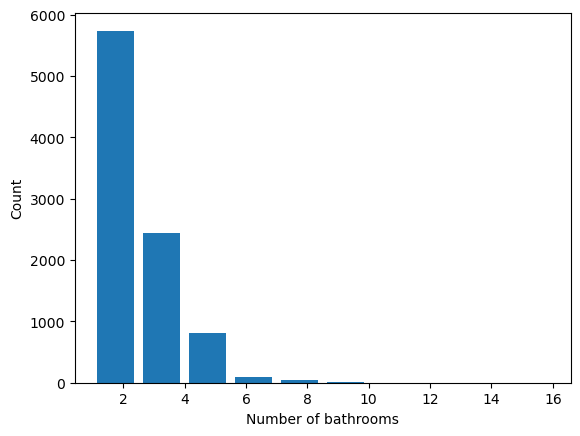

In [43]:
plt.hist(data.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

###### If N is the no of bedrooms, we can put up a rule that there can be upto N+2 bathrooms, anything over that maybe considered an outlier

In [44]:
#Detecting all such outliers
data[data.bath>10]
data[data.bath>data.BHK+2]

,location,size,total_sqft,bath,price,BHK,price_per_sqft
5140,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6615,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8294,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [45]:
data = data[data.bath<data.BHK+2]
data.shape

(9040, 7)

## Clean Data

In [46]:
#Dropping 'Size' Because we already have BHK column with much more meaningful data 
#Dropping 'Price_per_sqft' because it is only a feature we used to remove outliers
data = data.drop(columns=['size','price_per_sqft'],axis=1)

In [47]:
data.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


## Model Building

#### Import all the necessary Models

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score   #For K-fold cross validation
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import warnings
warnings.filterwarnings('ignore')

## One Hot Encoding

###### One-hot encoding is used in machine learning and data preprocessing to convert categorical data (which often consists of strings or labels) into a numerical format that can be fed into algorithms. We use this method on Location column

In [49]:
dummies = pd.get_dummies(data.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
data.columns

Index(['location', 'total_sqft', 'bath', 'price', 'BHK'], dtype='object')

In [51]:
dummies.columns

Index(['1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar', '6th Phase JP Nagar',
       '7th Phase JP Nagar', '8th Phase JP Nagar', '9th Phase JP Nagar',
       ...
       'Vishveshwarya Layout', 'Vishwapriya Layout', 'Vittasandra',
       'Whitefield', 'Yelachenahalli', 'Yelahanka', 'Yelahanka New Town',
       'Yelenahalli', 'Yeshwanthpur', 'other'],
      dtype='object', length=241)

#### Since the 'Other' in the location column does not have much relevance, we drop it

In [52]:
data = pd.concat([data,dummies.drop('other',axis='columns')],axis='columns')
data.head()

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [53]:
data = data.drop('location',axis='columns')
data.head(2)

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


###### Splitting the dataset into Test and Train sets

In [54]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['price'])
y = data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Applying Prediction Models

#### Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model with the training data
linear_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_linear)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_linear)

print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression R^2: {r2}")


Linear Regression MSE: 975.5062374648397
Linear Regression RMSE: 31.233095227095884
Linear Regression R^2: 0.8274085288349369


#### Decision Tree Regressor

In [56]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)

# Fit the model
decision_tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = decision_tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_tree)
# Evaluate the model
print(f"Decision Tree Regression MSE: {mse}")
print(f"Decision Tree Regression RMSE: {np.sqrt(mse)}")
print(f"Decision Tree Regression R^2: {r2_score(y_test, y_pred_tree)}")

Decision Tree Regression MSE: 1568.5410182448834
Decision Tree Regression RMSE: 39.60481054423671
Decision Tree Regression R^2: 0.72248583194591


#### Ranfom Forest Regressor

In [57]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Fit the model
random_forest_model.fit(X_train, y_train)

# Make predictions
y_pred_forest = random_forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_tree)

# Evaluate the model
print(f"Random Forest Regression MSE: {mse}")
print(f"Random Forest Regression RMSE: {np.sqrt(mse)}")
print(f"Random Forest Regression R^2: {r2_score(y_test, y_pred_forest)}")

Random Forest Regression MSE: 1568.5410182448834
Random Forest Regression RMSE: 39.60481054423671
Random Forest Regression R^2: 0.7691780714701387


#### Xgboost

In [58]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the XGBoost Regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, random_state=42)

# Fit the model
xgboost_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgboost_model.predict(X_test)

# Compute MSE for XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# Compute RMSE for XGBoost Regression
rmse_xgb = np.sqrt(mse_xgb)

# Compute R² score for XGBoost Regression
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the results
print(f"XGBoost Regression MSE: {mse_xgb}")
print(f"XGBoost Regression RMSE: {rmse_xgb}")
print(f"XGBoost Regression R² Score: {r2_xgb}")


XGBoost Regression MSE: 1135.0539354033783
XGBoost Regression RMSE: 33.69056151807771
XGBoost Regression R² Score: 0.7991805474539322


#### Comparing the RMSE Values for 4 models

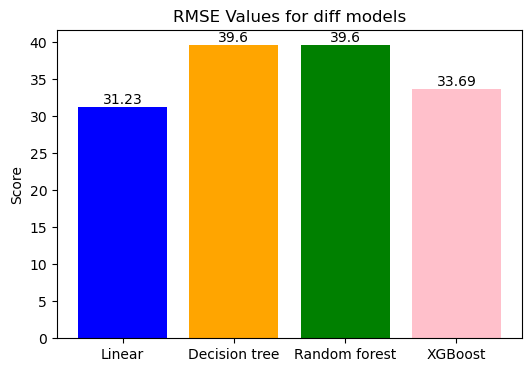

In [59]:
import matplotlib.pyplot as plt

lr= 31.233095227095884
decision_tree= 39.60481054423671
rf= 39.60481054423671

# Names for the metrics
metrics = ['Linear', 'Decision tree','Random forest', 'XGBoost']

# Values corresponding to the metrics
values = [lr, decision_tree, rf, rmse_xgb]

# Create a bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'green', 'pink'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


# Add labels and title
plt.ylabel('Score')
plt.title('RMSE Values for diff models')

# Display the bar plot
plt.show()

### HyperParameter Tuning for Random forest regressor

#### Hyperparameter tuning refers to the process of optimizing the hyperparameters of a machine learning model to improve its performance. Unlike model parameters, which are learned from the data during training (such as the weights in a linear regression), hyperparameters are set before training and determine the behavior of the model.

#### Hyper Parameter Tuning for Linear Regression

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid for polynomial degrees and whether to include bias or not
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5],  # Polynomial degrees to try
    'polynomialfeatures__include_bias': [False, True],  # Whether to include bias
    'linear_model__fit_intercept': [True, False]  # Whether to fit the intercept term
}

# Initialize PolynomialFeatures and Linear Regression in a Pipeline
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('linear_model', LinearRegression())
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator and hyperparameters
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_linear = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_linear)
rmse_lr_hyp = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_linear)

# Print the results
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression RMSE: {rmse_lr_hyp}")
print(f"Linear Regression R^2: {r2}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'linear_model__fit_intercept': True, 'polynomialfeatures__degree': 1, 'polynomialfeatures__include_bias': False}
Linear Regression MSE: 975.5062374650558
Linear Regression RMSE: 31.233095227099344
Linear Regression R^2: 0.8274085288348987


#### Hyperparameter Tuning for Random Forest Regressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the parameter grid with a reduced number of hyperparameters
param_distributions = {
    'n_estimators': [50, 100, 200],                # Number of trees in the forest
    'max_depth': [5, 10, 20, None],                # Maximum depth of the trees
    'min_samples_split': [2, 4, 5],               # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 3, 4],                # Minimum number of samples at each leaf node
    'bootstrap': [True, False]                 # Bootstrap sampling or not
}

# Initialize the Random Forest Regressor
random_forest_hyp_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_distributions, 
                                   n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42, 
                                   scoring='neg_mean_squared_error')

# Fit the model with RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and the tuned model
best_random_forest = random_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_forest = best_random_forest.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred_forest)
rmse_Hyp_rf = np.sqrt(mse)

# Evaluate the model
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Random Forest Regression MSE: {mse}")
print(f"Random Forest Regression RMSE: {rmse_Hyp_rf}")
print(f"Random Forest Regression R^2: {r2_score(y_test, y_pred_forest)}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Random Forest Regression MSE: 1008.2392425415321
Random Forest Regression RMSE: 31.752783225121103
Random Forest Regression R^2: 0.8216172409016873


#### Hyperparameter Tuning for Decision Tree Regressor

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],               # Depth of the tree
    'min_samples_split': [2, 5, 10],             # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2']       # Number of features to consider when looking for the best split
}

# Initialize the Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and the tuned model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_tree_best = best_model.predict(X_test)

# Calculate MSE, RMSE, and R^2 for the best model
mse_best = mean_squared_error(y_test, y_pred_tree_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_tree_best)

# Print out the results
print(f"Best Hyperparameters: {best_params}")
print(f"Tuned Decision Tree Regression MSE: {mse_best}")
print(f"Tuned Decision Tree Regression RMSE: {rmse_best}")
print(f"Tuned Decision Tree Regression R^2: {r2_best}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Tuned Decision Tree Regression MSE: 1409.960706095074
Tuned Decision Tree Regression RMSE: 37.54944348582378
Tuned Decision Tree Regression R^2: 0.7505426585663928


#### HyperParameter Tuning for Xgboost

In [63]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid for XGBoost hyperparameters
param_distributions = {
    'n_estimators': [100, 200, 300],                # Number of trees
    'max_depth': [3, 5, 7, 10],                     # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        # Learning rate (shrinkage)
    'subsample': [0.6, 0.8, 1.0],                   # Fraction of samples to be used for fitting individual trees
    'colsample_bytree': [0.6, 0.8, 1.0],            # Fraction of features to be used for fitting individual trees
    'gamma': [0, 0.1, 0.2, 0.3],                    # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.01, 0.1, 1],                 # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]                 # L2 regularization
}

# Initialize the XGBoost Regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_distributions,
                                       n_iter=50, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error',
                                       random_state=42)

# Fit the model with RandomizedSearchCV
random_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters and best model
best_xgboost_model = random_search_xgb.best_estimator_

# Make predictions on the test data using the best model
y_pred_xgb = best_xgboost_model.predict(X_test)

# Compute MSE for XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# Compute RMSE for XGBoost Regression
rmse_hyp_xgb = np.sqrt(mse_xgb)

# Compute R² score for XGBoost Regression
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the best parameters and results
print(f"Best Hyperparameters: {random_search_xgb.best_params_}")
print(f"XGBoost Regression MSE: {mse_xgb}")
print(f"XGBoost Regression RMSE: {rmse_hyp_xgb}")
print(f"XGBoost Regression R² Score: {r2_xgb}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
XGBoost Regression MSE: 1154.73955738304
XGBoost Regression RMSE: 33.98145902375352
XGBoost Regression R² Score: 0.7956976681777332


### Comparing RMSE of all models post HyperParameter tuning

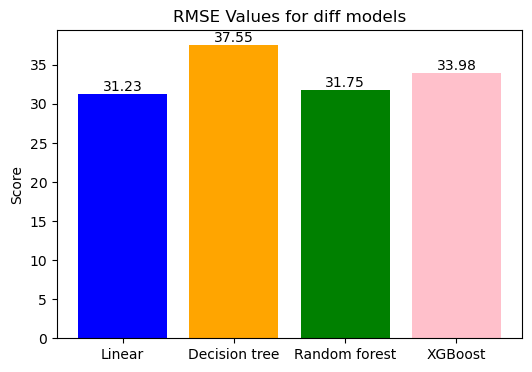

In [64]:
import matplotlib.pyplot as plt


# Names for the metrics
metrics = ['Linear', 'Decision tree','Random forest', 'XGBoost']

# Values corresponding to the metrics
values = [rmse_lr_hyp, rmse_best, rmse_Hyp_rf, rmse_hyp_xgb]

# Create a bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'green', 'pink'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


# Add labels and title
plt.ylabel('Score')
plt.title('RMSE Values for diff models')

# Display the bar plot
plt.show()

#### Comparing Before Vs After HyperParameter Tuning

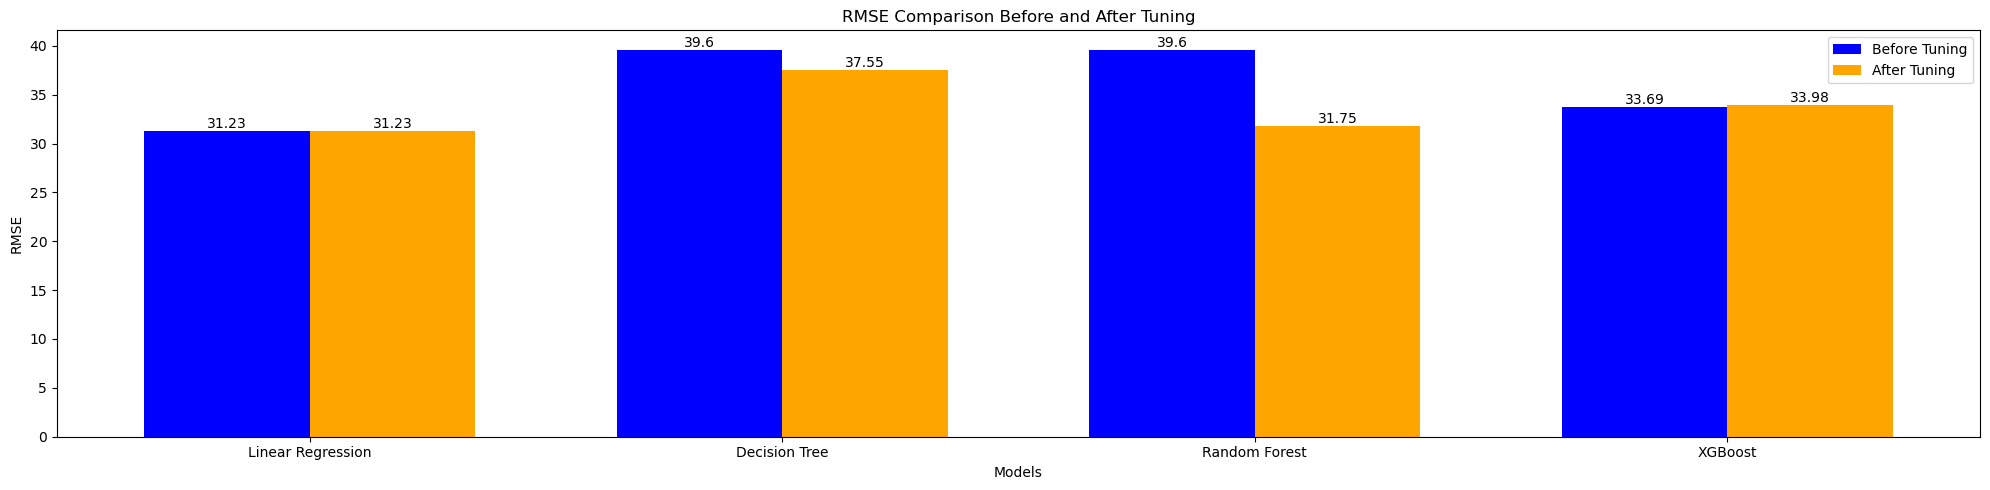

In [65]:
import matplotlib.pyplot as plt
import numpy as np

before_rmse = {
    'Linear Regression': lr,
    'Decision Tree': decision_tree,
    'Random Forest': rf,
    'XGBoost': rmse_xgb
}

after_rmse = {
    'Linear Regression': rmse_lr_hyp,
    'Decision Tree': rmse_best,
    'Random Forest': rmse_Hyp_rf,
    'XGBoost': rmse_hyp_xgb
}

# Extract models and values
models = list(before_rmse.keys())
before_rmse_values = list(before_rmse.values())
after_rmse_values = list(after_rmse.values())

# Set up the plot
plt.figure(figsize=(20, 5))
bar_width = 0.35  # Width of the bars
index = np.arange(len(models))  # The x locations for the groups

# Plot before tuning bars
bars_before = plt.bar(index, before_rmse_values, bar_width, label='Before Tuning', color='blue')

# Plot after tuning bars next to them
bars_after = plt.bar(index + bar_width, after_rmse_values, bar_width, label='After Tuning', color='orange')

# Add text labels on top of the bars
for bar in bars_before:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars_after:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison Before and After Tuning')
plt.xticks(index + bar_width / 2, models)  # Adjust x-axis ticks to be in the center of both bars
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


###### Based on both the lower RMSE and the higher R², the model after hyperparameter tuning is clearly better. Therefore, we use the model after hyperparameter tuning for your predictions.

### From the above, we can observe the Linear Regression has the best RMSE Value, so we consider Linear Regression to be the best Model for this problem

In [66]:
test = pd.read_csv(r"C:\Users\LENOVO\Downloads\Test.csv")

In [67]:
test

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...
1475,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,NaN
1476,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,NaN
1477,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,NaN
1478,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,NaN


#### Predicting the Price using Location, Size, Bath and BHK Values

In [68]:
def predict_price(location, sqft, bath, bhk):
    # Find the index of the location in the one-hot encoded matrix
    try:
        loc_index = np.where(X.columns == location)[0][0]
    except IndexError:
        loc_index = -1  # Location is not found in the dataset

    # Create a zero array with the size of the feature matrix
    x = np.zeros(len(X.columns))
    
    # Assign the input values to the respective indices
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    
    # Set the location feature to 1 if it's found in the dataset
    if loc_index >= 0:
        x[loc_index] = 1

    # Use the trained random forest model to predict the price
    return linear_model.predict([x])[0]

# Example usage of the function
location = '1st Phase JP Nagar'  # Replace with the location you're interested in
sqft = 1000  # Enter the square feet of the property
bath = 2     # Enter the number of bathrooms
bhk = 2      # Enter the number of bedrooms

predicted_price = predict_price(location, sqft, bath, bhk)
print(f"Predicted price for a {bhk} BHK house in {location} with {sqft} sqft and {bath} bathrooms is: {predicted_price:.2f}")


Predicted price for a 2 BHK house in 1st Phase JP Nagar with 1000 sqft and 2 bathrooms is: 86.97


In [69]:
location = 'Whitefield'  
sqft = 1000
bath = 2     
bhk = 3     

predicted_price = predict_price(location, sqft, bath, bhk)
print(f"Predicted price for a {bhk} BHK house in {location} with {sqft} sqft and {bath} bathrooms is: {predicted_price:.2f}")


Predicted price for a 3 BHK house in Whitefield with 1000 sqft and 2 bathrooms is: 43.32


In [70]:
location = 'Hennur road'  
sqft = 2000
bath = 3    
bhk = 4    

predicted_price = predict_price(location, sqft, bath, bhk)
print(f"Predicted price for a {bhk} BHK house in {location} with {sqft} sqft and {bath} bathrooms is: {predicted_price:.2f}")

Predicted price for a 4 BHK house in Hennur road with 2000 sqft and 3 bathrooms is: 133.45


In [71]:
location = 'Sarjapur Road'  
sqft = 1500
bath = 2    
bhk = 3   

predicted_price = predict_price(location, sqft, bath, bhk)
print(f"Predicted price for a {bhk} BHK house in {location} with {sqft} sqft and {bath} bathrooms is: {predicted_price:.2f}")

Predicted price for a 3 BHK house in Sarjapur Road with 1500 sqft and 2 bathrooms is: 94.59
